In [1]:
from pytorch_forecasting import TimeSeriesDataSet, TemporalFusionTransformer
from pytorch_forecasting.metrics import QuantileLoss
import pandas as pd
from pathlib import Path
import pytorch_lightning as pl

main_dir = Path().absolute().parent

/home/cdellefemine/.conda/envs/dl/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
training_data = pd.read_csv(main_dir/'data'/'cleaned'/'energy/train_set_imp.csv')
training_data['date'] = pd.to_datetime(training_data['date'])

In [3]:
training_data['time_idx'] = training_data['date'].astype(int)/1e9
training_data['time_idx'] -= training_data['time_idx'].min()
training_data['group_ids'] = 0
training_data['time_idx'] = (training_data['time_idx']/900).astype(int)
training_data['month'] = training_data['date'].dt.month.astype(str).astype("category")
training_data['hour'] = training_data['date'].dt.hour.astype(str).astype("category")
training_data['day'] = training_data['date'].dt.dayofweek.astype(str).astype("category")
training_data.drop('date', axis = 1, inplace = True)


In [52]:
validation_data = pd.read_csv(main_dir/'data'/'cleaned'/'energy/valid_set_imp.csv')
validation_data['date'] = pd.to_datetime(validation_data['date'])

validation_data['time_idx'] = validation_data['date'].astype(int)/1e9
validation_data['time_idx'] -= validation_data['time_idx'].min()
validation_data['group_ids'] = 0
validation_data['time_idx'] = (validation_data['time_idx']/900).astype(int)
validation_data['month'] = validation_data['date'].dt.month.astype(str).astype("category")
validation_data['hour'] = validation_data['date'].dt.hour.astype(str).astype("category")
validation_data['day'] = validation_data['date'].dt.dayofweek.astype(str).astype("category")
validation_data.drop('date', axis = 1, inplace = True)

In [53]:
validation = TimeSeriesDataSet.from_dataset(training, validation_data, stop_randomization=True)
train_dataloader = training.to_dataloader(train=True, batch_size = 64, num_workers = 24)
validation_dataloader = validation.to_dataloader(train=False, batch_size = 64, num_workers = 24)

In [89]:
from tokenize import group
scalers = {}
 
for x in training_data.columns:
    if x not in ['month', 'day', 'hour', 'hvac']:
        scalers[x] = None

training = TimeSeriesDataSet(
    training_data,
    time_idx = 'time_idx',
    group_ids = ['group_ids'],
    target = 'hvac',
    max_encoder_length=96*3,
    max_prediction_length = 4*12,
    time_varying_unknown_categoricals = ['month', 'hour', 'day'],
    time_varying_unknown_reals = [x for x in training_data.columns if (x not in ['month', 'day', 'hour','air_temp_set_1', 'air_temp_set_2', 'dew_point_temperature_set_1d', 'relative_humidity_set_1', 'solar_radiation_set_1'])],
    time_varying_known_reals = ['air_temp_set_1', 'air_temp_set_2', 'dew_point_temperature_set_1d', 'relative_humidity_set_1', 'solar_radiation_set_1'],
    target_normalizer=None,
    scalers = scalers,
)

validation = TimeSeriesDataSet.from_dataset(training, validation_data, stop_randomization=True)
train_dataloader = training.to_dataloader(train=True, batch_size = 64, num_workers = 24)
validation_dataloader = validation.to_dataloader(train=False, batch_size = 64, num_workers = 24)

In [81]:
training

TimeSeriesDataSet[length=75655](
	time_idx='time_idx',
	target='hvac',
	group_ids=['group_ids'],
	weight=None,
	max_encoder_length=96,
	min_encoder_length=96,
	min_prediction_idx=0,
	min_prediction_length=4,
	max_prediction_length=4,
	static_categoricals=[],
	static_reals=[],
	time_varying_known_categoricals=[],
	time_varying_known_reals=['air_temp_set_1', 'air_temp_set_2', 'dew_point_temperature_set_1d', 'relative_humidity_set_1', 'solar_radiation_set_1'],
	time_varying_unknown_categoricals=['month', 'hour', 'day'],
	time_varying_unknown_reals=['zone_016_cooling_sp', 'zone_017_cooling_sp', 'zone_018_cooling_sp', 'zone_019_cooling_sp', 'zone_021_cooling_sp', 'zone_023_cooling_sp', 'zone_024_cooling_sp', 'zone_025_cooling_sp', 'zone_026_cooling_sp', 'zone_027_cooling_sp', 'zone_030_cooling_sp', 'zone_032_cooling_sp', 'zone_035_cooling_sp', 'zone_036_cooling_sp', 'zone_037_cooling_sp', 'zone_038_cooling_sp', 'zone_039_cooling_sp', 'zone_041_cooling_sp', 'zone_042_cooling_sp', 'zone_043_c

In [14]:
x, y = next(iter(train_dataloader))
print(x.keys())

dict_keys(['encoder_cat', 'encoder_cont', 'encoder_target', 'encoder_lengths', 'decoder_cat', 'decoder_cont', 'decoder_target', 'decoder_lengths', 'decoder_time_idx', 'groups', 'target_scale'])


In [90]:
tft = TemporalFusionTransformer.from_dataset(
    training,
    learning_rate = 0.03,
    hidden_size = 16,
    attention_head_size = 4,
    dropout = 0.2,
    hidden_continuous_size = 8,
    output_size = 7,
    loss = QuantileLoss(),
    reduce_on_plateau_patience = 4,
)

/home/cdellefemine/.conda/envs/dl/lib/python3.10/site-packages/pytorch_lightning/utilities/parsing.py:261: UserWarning: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
  rank_zero_warn(
/home/cdellefemine/.conda/envs/dl/lib/python3.10/site-packages/pytorch_lightning/utilities/parsing.py:261: UserWarning: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['logging_metrics'])`.
  rank_zero_warn(


In [20]:
trainer = pl.Trainer(
    gradient_clip_val = 0.1,
    max_epochs = 10,
    limit_train_batches = 10,
)

res = trainer.tuner.lr_find(
    tft,
    train_dataloaders=train_dataloader,
    val_dataloaders=validation_dataloader,
    max_lr=10.0,
    min_lr=1e-6,
)

print(f"suggested learning rate: {res.suggestion()}")
fig = res.plot(show=True, suggest=True)
fig.show()

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


OSError: [Errno 12] Cannot allocate memory

In [92]:
trainer = pl.Trainer(
    accelerator = 'cpu',
    gradient_clip_val = 0.1,
    max_epochs = 1,
    limit_train_batches = 0.5
)

trainer.fit(tft, train_dataloader, validation_dataloader)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

   | Name                               | Type                            | Params
----------------------------------------------------------------------------------------
0  | loss                               | QuantileLoss                    | 0     
1  | logging_metrics                    | ModuleList                      | 0     
2  | input_embeddings                   | MultiEmbedding                  | 323   
3  | prescalers                         | ModuleDict                      | 3.8 K 
4  | static_variable_selection          | VariableSelectionNetwork        | 0     
5  | encoder_variable_selection         | VariableSelectionNetwork        | 166 K 
6  | decoder_variable_selection         | VariableSelectionNetwork        | 3.0 K 
7  | static_context_variable_selection  | GatedResidualNetwork            | 1.1 K 
8  | static_cont

Epoch 0:   0%|          | 0/716 [00:00<?, ?it/s]                           

OSError: [Errno 12] Cannot allocate memory

In [87]:
predictions, x = tft.predict(validation_dataloader, mode = 'raw', return_x=True)

In [57]:
predictions.keys()

('prediction',
 'encoder_attention',
 'decoder_attention',
 'static_variables',
 'encoder_variables',
 'decoder_variables',
 'decoder_lengths',
 'encoder_lengths')

In [64]:
predictions['prediction'].shape

torch.Size([8318, 4, 7])

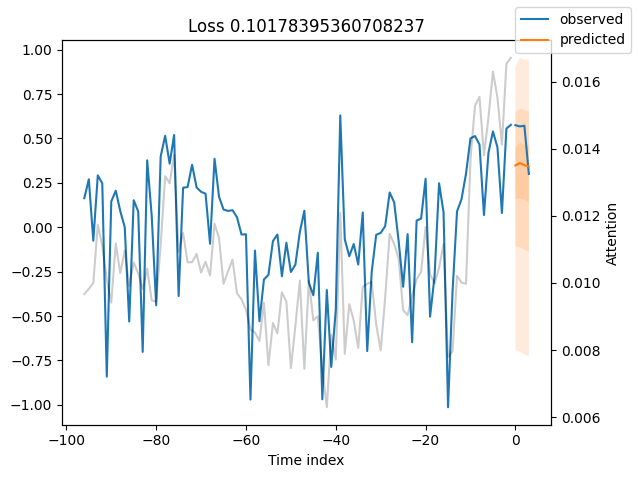

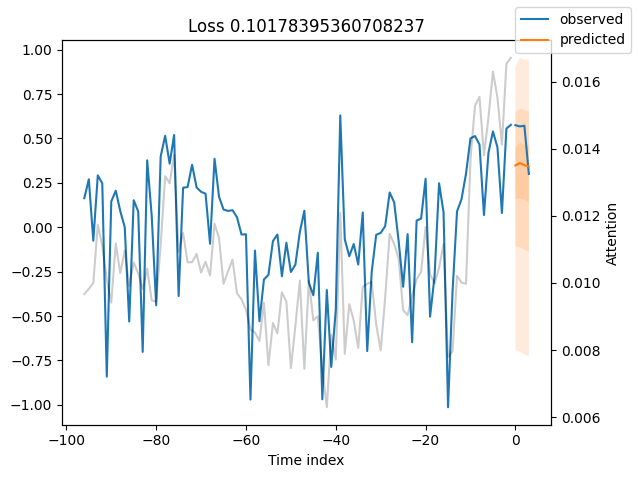

In [88]:
tft.plot_prediction(x, predictions, idx = 24, add_loss_to_title=True)

In [65]:
validation_data

,air_temp_set_1,air_temp_set_2,dew_point_temperature_set_1d,relative_humidity_set_1,solar_radiation_set_1,zone_016_cooling_sp,zone_017_cooling_sp,zone_018_cooling_sp,zone_019_cooling_sp,zone_021_cooling_sp,...,zone_069_hw_valve,zone_070_hw_valve,zone_071_hw_valve,zone_072_hw_valve,hvac,time_idx,group_ids,month,hour,day
0,-0.613365,-0.337612,-0.081429,-0.010040,-0.545146,0.766263,1.840024,0.747721,0.0,-0.130647,...,-0.855057,-1.274806,-1.011951,-1.016956,0.722893,0,0,2,3,5
1,-0.358063,0.225704,-0.140186,0.111999,-0.741947,1.699471,0.740989,0.747721,0.0,-0.130647,...,-0.874508,-1.274806,-1.011951,-1.080407,0.759499,1,0,2,3,5
2,-0.517218,-0.325736,-0.163178,0.179964,-0.741947,0.766263,0.740989,-0.578121,0.0,-0.130647,...,-0.874508,-1.274806,-1.011951,-1.016956,0.709042,2,0,2,4,5
3,-0.503360,0.857204,-0.196388,0.207745,-0.459392,0.766263,1.935199,0.747721,0.0,-0.130647,...,-0.874508,-1.274806,-1.011951,-1.016956,0.747874,3,0,2,4,5
4,-0.878198,0.453482,-0.175951,0.195343,-0.630133,0.766263,0.740989,0.747721,0.0,-0.130647,...,-0.874508,-1.274806,-1.061451,-1.016956,0.712504,4,0,2,4,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8412,1.318068,1.673368,0.703215,-1.355444,1.745945,0.766263,2.000634,-1.545641,0.0,-0.105005,...,-0.874508,-1.274806,-1.061451,-1.091394,1.750256,8412,0,5,18,1
8413,1.451290,2.036246,-0.089663,-1.559835,1.730173,2.254741,0.740989,-1.105713,0.0,-0.130647,...,-0.873797,-1.274775,-1.011951,-1.091765,0.973078,8413,0,5,18,1
8414,0.989777,1.962192,-0.282409,-1.783077,-0.132834,1.706774,0.740989,-1.545641,0.0,-0.130647,...,-0.866523,-1.274806,-1.011951,-1.074473,3.150200,8414,0,5,19,1
8415,1.098239,2.309355,0.743720,-1.831694,1.366007,0.766263,1.775293,-1.545641,0.0,0.242619,...,-0.874508,-1.274806,-1.061451,-1.016956,1.062442,8415,0,5,19,1
